In [1]:
import torch
import matplotlib.pyplot as plt
import os
import nibabel as nib
import pydicom as dicom
import cv2
from PIL import Image
import numpy as np

In [ ]:
dataset_path = r'D:\BraTS2021_Training_Data\\'

patients = os.listdir(dataset_path)

example_slices = []
for i, patient in enumerate(patients):
    
    dir_patient = dataset_path + patient
    
    if '_0' in dir_patient and i<200:
        with os.scandir(dir_patient) as entries:
            
            print(f"Opening patient files: {dir_patient}")
            for entry in entries:
                ## Unzip the compressed files
                if entry.is_file() and entry.name.endswith('.nii.gz'):  # Check for .nii.gz files
                    file_path = entry.path
                    idx_format = str.find(file_path, '.nii.gz')
                    unzipped_file = file_path[:idx_format]  
                    unzipped_file = unzipped_file + '.jpeg' 

                    # Load the .nii.gz file
                    nii_data = nib.load(file_path)
                    # print(nii_data.header)
                    img = nii_data.get_fdata()
                    
                    n_slices = img.shape[2]
                    slice = img[..., n_slices//2]
                    
                    # if '_flair' in unzipped_file:
                        # example_slices.append(slice)
                        # print(f"Shape of patient slice: {slice.shape}")
                        
                    plt.figure()
                    plt.imshow(slice, cmap='gray')
                    plt.axis('off')
                    plt.savefig(unzipped_file, format='jpeg', bbox_inches='tight', pad_inches=0)
                    plt.close()
        

Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00000
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00002
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00003
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00005
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00006
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00008
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00009
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00011
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00012
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00014
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00016
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00017
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00018
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_00019
Opening patient files: D:\BraTS2021_Training_Data\\BraTS2021_0

In [15]:
output_path = r'D:\BraTS2021_preprocessed\\'

patients = os.listdir(dataset_path)

example_slices = []
for i, patient in enumerate(patients):
    
    if '_0' in patient and i<200: 
        dir_patient = dataset_path + patient
        
        files = os.listdir(dir_patient)
        for file in files:
            
            if '.jpeg' in file:
                in_dir = dir_patient + '\\' + file
                img = Image.open(in_dir)
                
                im_rot = img.rotate(90)
                im_resized = im_rot.resize((512,512), Image.Resampling.LANCZOS)
                
                out_dir = output_path + file
                im_resized.save(out_dir, 'jpeg')
            
            

In [2]:
def get_tumor_mask(segmentation_mask):
    tumor_mask = (segmentation_mask > 0).astype(int)
    segmentation_mask
    return tumor_mask


def get_size(tumor):
    return np.sum(tumor)


def get_coordinates(tumor_mask):
    tumor_idx = np.where(tumor_mask == 1)
    
    start_x, start_y = np.min(tumor_idx[0]), np.min(tumor_idx[1])
    end_x, end_y = np.max(tumor_idx[0]), np.max(tumor_idx[1])

    mid_point_x = int((start_x + end_x)/2)
    mid_point_y = int((start_y + end_y)/2)
    
    return mid_point_x, mid_point_y


def get_position_label(tumor_mask):
    mid_point_x, mid_point_y = get_coordinates(tumor_mask)
    bound = 512 / 2
    center_th = 10

    # Tumors on the bottom / top side of the brain
    if mid_point_x > bound + center_th and mid_point_y > bound + center_th:
        label = 'bottom right'

    elif mid_point_x > bound + center_th and mid_point_y < bound - center_th :
        label = 'bottom left'
            
    elif mid_point_x < bound - center_th and mid_point_y > bound + center_th:
        label = 'top right'
        
    elif mid_point_x < bound - center_th and mid_point_y < bound - center_th:
        label = 'top left'
            
    # Tumors on the center of the brain (center left/ right)
    else:
        if mid_point_y > bound + center_th:
            label = 'center right'
        elif mid_point_y < bound - center_th:
            label = 'center left'
        else:
            label = 'center'
            
    return label

In [3]:
import os
import shutil

# Define dataset path and output base path
dataset_path = r'D:\BraTS2021_preprocessed\\'
output_base_path = r'D:\BraTS2021_train_final'

# List of modalities
modalities = ['Flair', 't1ce', 't1', 't2', 'seg']

# Ensure output directories exist
for modality in modalities:
    os.makedirs(os.path.join(output_base_path, modality), exist_ok=True)

# List all files in the dataset directory
files = os.listdir(dataset_path)

# Process each file
for file in files:
    dir_file = os.path.join(dataset_path, file)

    # Determine the modality and set the corresponding output directory
    if '_flair' in file:
        modality = 'Flair'
    elif '_t1ce' in file:
        modality = 't1ce'
    elif '_t1' in file and '_t1ce' not in file:
        modality = 't1'
    elif '_t2' in file:
        modality = 't2'
    elif '_seg' in file:  # Skip segmentation files
        modality = 'seg'
    else:
        print(f"Unknown modality for file: {file}")
        continue

    # Build the new file name and output path
    file_idx = file.find('_' + modality.lower())  # Adjust modality for filenames
    file_name = file[:file_idx] + '.jpeg'
    out_path = os.path.join(output_base_path, modality, file_name)

    # Copy the file to the output folder
    shutil.copy(dir_file, out_path)
    print(f"Copied {file} to {out_path}")

print("File separation complete!")


Copied BraTS2021_00000_flair.jpeg to D:\BraTS2021_train_final\Flair\BraTS2021_00000.jpeg
Copied BraTS2021_00000_seg.jpeg to D:\BraTS2021_train_final\seg\BraTS2021_00000.jpeg
Copied BraTS2021_00000_t1.jpeg to D:\BraTS2021_train_final\t1\BraTS2021_00000.jpeg
Copied BraTS2021_00000_t1ce.jpeg to D:\BraTS2021_train_final\t1ce\BraTS2021_00000.jpeg
Copied BraTS2021_00000_t2.jpeg to D:\BraTS2021_train_final\t2\BraTS2021_00000.jpeg
Copied BraTS2021_00002_flair.jpeg to D:\BraTS2021_train_final\Flair\BraTS2021_00002.jpeg
Copied BraTS2021_00002_seg.jpeg to D:\BraTS2021_train_final\seg\BraTS2021_00002.jpeg
Copied BraTS2021_00002_t1.jpeg to D:\BraTS2021_train_final\t1\BraTS2021_00002.jpeg
Copied BraTS2021_00002_t1ce.jpeg to D:\BraTS2021_train_final\t1ce\BraTS2021_00002.jpeg
Copied BraTS2021_00002_t2.jpeg to D:\BraTS2021_train_final\t2\BraTS2021_00002.jpeg
Copied BraTS2021_00003_flair.jpeg to D:\BraTS2021_train_final\Flair\BraTS2021_00003.jpeg
Copied BraTS2021_00003_seg.jpeg to D:\BraTS2021_train_fin

In [9]:
import os
import cv2
import csv
csv_files = []

for csv_file in csv_files:
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        csv_writer = csv.writer(file)
        # Write header row
        csv_writer.writerow(['Image File', 'Prompt'])

# Define paths
out_dirs = [r'D:\BraTS2021_train_final\t1', r'D:\BraTS2021_train_final\t1ce', r'D:\BraTS2021_train_final\t2', r'D:\BraTS2021_train_final\Flair']
modalities = ['t1', 't1ce', 't2', 'flair']

ref_dir = r'D:\BraTS2021_train_final\seg'

q4 = 19000
q1 = 5900

# Loop through segmentation files
for i, file in enumerate(os.listdir(ref_dir)):

    # Process the segmentation file
    dir_file = os.path.join(ref_dir, file)

    # Read the mask
    mask = cv2.imread(dir_file, cv2.IMREAD_GRAYSCALE)
    
    # Process tumor mask
    tumor_mask = get_tumor_mask(mask)
    tumor_size = get_size(tumor_mask)

    # Loop through each modality and output directory
    for j, modality in enumerate(modalities):
        out_dir = out_dirs[j]
        
        # Metadata CSV path
        csv_file = os.path.join(out_dir, 'metadata.csv')

        # Generate prompt
        if tumor_size > 0:
            position = get_position_label(tumor_mask)
            if tumor_size >= q4:
                size = 'large'
            elif tumor_size > q1:
                size = 'medium'
            else:
                size = 'small'
            prompt = f'Brain MRI {modality}, with {size} tumor, on the {position}'
        else:
            prompt = f'Brain MRI {modality} healthy'

        # Save the processed image (example placeholder, replace with actual image if needed)
        # cv2.imwrite(file_path, mask)

        if i == 0:
            with open(csv_file, mode='w', newline='', encoding='utf-8') as csv_file_obj:
                    csv_writer = csv.writer(csv_file_obj, )
                    # Write header row
                    csv_writer.writerow(['file_name', 'text'])

        # Write metadata to CSV
        with open(csv_file, mode='a', newline='', encoding='utf-8') as csv_file_obj:
            csv_writer = csv.writer(csv_file_obj)
            # Write metadata to CSV
            csv_writer.writerow([file, prompt])
            
# print("Processing complete. Metadata written to CSV files.")


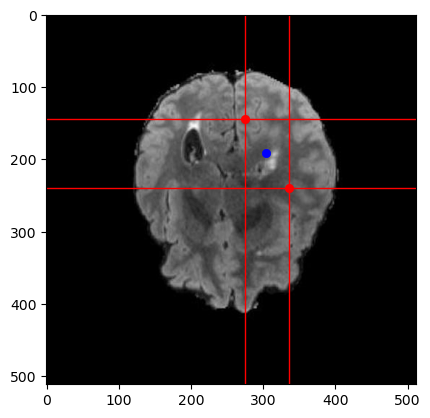

In [ ]:
## Visualize tumor position
plt.figure()
plt.imshow(img_flair, cmap='gray')

plt.scatter(start_y, start_x, color='red',linewidth=.5)

plt.axvline(start_y, color='red', linewidth=1)
plt.axhline(start_x, color='red', linewidth=1)

plt.axvline(end_y, color='red', linewidth=1)
plt.axhline(end_x, color='red', linewidth=1)
plt.scatter(end_y, end_x, color='red',linewidth=.5)

plt.scatter(mid_point_y, mid_point_x, color='blue',linewidth=.5)